In [1]:
import time 
import numpy as np
import pandas as pd 
import os 
import gc 

In [2]:
from sklearn import metrics 
from sklearn.metrics import mean_squared_error 
from sklearn import feature_selection 
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing 

In [3]:
import lightgbm as lgb 
from sklearn.linear_model import Ridge 
from sklearn.cross_validation import KFold 
# Tf-Idf 単語ベクトル系
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.pipeline import FeatureUnion 
from scipy.sparse import hstack, csr_matrix 
from nltk.corpus import stopwords 
# 可視化
import seaborn as sns 
import matplotlib.pyplot as plt 
import re 
import string 

/Users/oharasoh/.pyenv/versions/3.5.3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
NFOLDS = 5 
SEED = 42 
VALID = True 
# Sklearnのオブジェクトを入れるためのクラス？
# clfは決定木関連
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None, seed_bool=True):
        if(seed_bool == True):
            params['random_state'] = seed 
        self.clf = clf(**params) 
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train) 
        
    def predict(self, x):
        return self.clf.predict(x) 
# oofって何だろう。
def get_oof(clf, x_train, y, x_test):
    oof_train = np.zeros((ntrain,)) 
    oof_test = np.zeros((ntest,)) 
    oof_test_skf = np.empty((NFOLDS, ntest)) 
    
    for i, (train_index, test_index) in enumerate(kf):
        print("Fold {}".format(i)) 
        x_tr = x_train[train_index] 
        y_tr = y[train_index] 
        x_te = x_train[test_index] 
        
        clf.train(x_tr, y_tr) 
        
        oof_train[test_index] = clf.predict(x_te) 
        oof_test_skf[i, :] = clf.predict(x_test) 
    oof_test[:] = oof_test_skf.mean(axis=0) 
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1) 


def cleanName(text):
    try: 
        textProc = text.lower() 
        # textPro = " ".jpin(map(str.strip, re.split('(\d+)', textProc)))
        # regex = re.compile(u'[^[:alpha:]]')
        # textProc = regex.sub(" ", textProc) 
        textProc = re.sub('[!@#$_“”¨«»®´·º½¾¿¡§£₤‘’]', '', textProc)
        textProc = " ".join(textProc.split()) 
        return textProc 
    except:
        return "name error" 
    
def rmse(y, y0):
    assert len(y) == len(y0) 
    return np.sqrt(np.mean(np.power((y - y0), 2)))

In [5]:
text = "I am you you and and II I!! I don't want you to sleep."
text = re.split('(\d+)', text)

In [6]:
text

["I am you you and and II I!! I don't want you to sleep."]

In [7]:
text = map(str.strip, text)

In [8]:
text

In [9]:
" ".join(text)

"I am you you and and II I!! I don't want you to sleep."

In [10]:
training = pd.read_csv("train.csv", index_col="item_id", 
                      parse_dates = ["activation_date"], nrows=10000) 
traindex = training.index 
# testing = pd.read_csv("test.csv", index_col="item_id",
#                     parse_dates = ["activation_date"], nrows=100)
testing = pd.read_csv("train.csv", index_col = "item_id", 
                      parse_dates= ["activation_date"], nrows=20000)
testing = testing[10000:]
testdex = testing.index 

In [11]:
testing.shape

(10000, 17)

In [12]:
ntrain = training.shape[0] 
ntest = testing.shape[0] 

kf = KFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=SEED) 

y = training.deal_probability.copy() 
training.drop("deal_probability", axis=1, inplace=True)  
print("Train shape: {} Rows, {} Columns".format(*training.shape))
print("Test shape: {} Rows, {} Columns".format(*testing.shape))

Train shape: 10000 Rows, 16 Columns
Test shape: 10000 Rows, 17 Columns


In [13]:
df = pd.concat([training, testing], axis=0) 
validation = testing["deal_probability"] 
# df = pd.concat([training, testing], axis=0)
del training, testing 


In [14]:
validation.head()

item_id
caca718b7a20    0.24829
c73daf8d5d27    0.00000
6c3780015c1d    0.00000
efff384be340    0.00000
3d17e5ae66d3    0.00000
Name: deal_probability, dtype: float64

In [15]:
print("All Data Shape: {} Rows, {} Columns".format(*df.shape))

All Data Shape: 20000 Rows, 17 Columns


In [16]:
df.head()

,activation_date,category_name,city,deal_probability,description,image,image_top_1,item_seq_number,param_1,param_2,param_3,parent_category_name,price,region,title,user_id,user_type
item_id,,,,,,,,,,,,,,,,,
b912c3c6a6ad,2017-03-28,Товары для детей и игрушки,Екатеринбург,NaN,"Кокон для сна малыша,пользовались меньше месяц...",d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,2,Постельные принадлежности,NaN,NaN,Личные вещи,400.0,Свердловская область,Кокоби(кокон для сна),e00f8ff2eaf9,Private
2dac0150717d,2017-03-26,Мебель и интерьер,Самара,NaN,"Стойка для одежды, под вешалки. С бутика.",79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,19,Другое,NaN,NaN,Для дома и дачи,3000.0,Самарская область,Стойка для Одежды,39aeb48f0017,Private
ba83aefab5dc,2017-03-20,Аудио и видео,Ростов-на-Дону,NaN,"В хорошем состоянии, домашний кинотеатр с blu ...",b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,9,"Видео, DVD и Blu-ray плееры",NaN,NaN,Бытовая электроника,4000.0,Ростовская область,Philips bluray,91e2f88dd6e3,Private
02996f1dd2ea,2017-03-25,Товары для детей и игрушки,Набережные Челны,NaN,Продам кресло от0-25кг,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,286,Автомобильные кресла,NaN,NaN,Личные вещи,2200.0,Татарстан,Автокресло,bf5cccea572d,Company
7c90be56d2ab,2017-03-16,Автомобили,Волгоград,NaN,Все вопросы по телефону.,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,3,С пробегом,ВАЗ (LADA),2110,Транспорт,40000.0,Волгоградская область,"ВАЗ 2110, 2003",ef50846afc0b,Private


In [17]:
df["price"] = np.log(df["price"] + 0.001 ) 
df["price"].fillna(df.price.mean(), inplace=True) # 平均で埋める
df["image_top_1"].fillna(-999, inplace=True) 

df["Weekday"] = df["activation_date"].dt.weekday 
df["Weekd of YEar"] = df["activation_date"].dt.week 
df["Day of Month"] = df["activation_date"].dt.day 

training_index = df.loc[df.activation_date<=pd.to_datetime("2017-04-07")
                       ].index 
validation_index = df.loc[df.activation_date>=pd.to_datetime('2017-04-08')
                         ].index


In [18]:
training_index[:10]

Index(['b912c3c6a6ad', '2dac0150717d', 'ba83aefab5dc', '02996f1dd2ea',
       '7c90be56d2ab', '51e0962387f7', 'c4f260a2b48a', '6b71309d6a8a',
       'c5b969cb63a2', 'b1570962e68c'],
      dtype='object', name='item_id')

In [19]:
df.drop(["activation_date", "image"], axis=1, inplace=True) 

In [20]:
df.head()

,category_name,city,deal_probability,description,image_top_1,item_seq_number,param_1,param_2,param_3,parent_category_name,price,region,title,user_id,user_type,Weekday,Weekd of YEar,Day of Month
item_id,,,,,,,,,,,,,,,,,,
b912c3c6a6ad,Товары для детей и игрушки,Екатеринбург,NaN,"Кокон для сна малыша,пользовались меньше месяц...",1008.0,2,Постельные принадлежности,NaN,NaN,Личные вещи,5.991467,Свердловская область,Кокоби(кокон для сна),e00f8ff2eaf9,Private,1,13,28
2dac0150717d,Мебель и интерьер,Самара,NaN,"Стойка для одежды, под вешалки. С бутика.",692.0,19,Другое,NaN,NaN,Для дома и дачи,8.006368,Самарская область,Стойка для Одежды,39aeb48f0017,Private,6,12,26
ba83aefab5dc,Аудио и видео,Ростов-на-Дону,NaN,"В хорошем состоянии, домашний кинотеатр с blu ...",3032.0,9,"Видео, DVD и Blu-ray плееры",NaN,NaN,Бытовая электроника,8.294050,Ростовская область,Philips bluray,91e2f88dd6e3,Private,0,12,20
02996f1dd2ea,Товары для детей и игрушки,Набережные Челны,NaN,Продам кресло от0-25кг,796.0,286,Автомобильные кресла,NaN,NaN,Личные вещи,7.696213,Татарстан,Автокресло,bf5cccea572d,Company,5,12,25
7c90be56d2ab,Автомобили,Волгоград,NaN,Все вопросы по телефону.,2264.0,3,С пробегом,ВАЗ (LADA),2110,Транспорт,10.596635,Волгоградская область,"ВАЗ 2110, 2003",ef50846afc0b,Private,3,11,16


In [21]:
categorical = ["user_id", "region", "city", "parent_category_name", 
               "category_name","user_type", "image_top_1", "param_1", 
               "param_2", "param_3"]
print("Encoding : ", categorical) 

lbl = preprocessing.LabelEncoder() 
for col in categorical:
    df[col].fillna("Unknown") 
    df[col] = lbl.fit_transform(df[col].astype(str)) 

Encoding :  ['user_id', 'region', 'city', 'parent_category_name', 'category_name', 'user_type', 'image_top_1', 'param_1', 'param_2', 'param_3']


In [22]:
df.head()

,category_name,city,deal_probability,description,image_top_1,item_seq_number,param_1,param_2,param_3,parent_category_name,price,region,title,user_id,user_type,Weekday,Weekd of YEar,Day of Month
item_id,,,,,,,,,,,,,,,,,,
b912c3c6a6ad,42,198,NaN,"Кокон для сна малыша,пользовались меньше месяц...",12,2,188,45,296,4,5.991467,19,Кокоби(кокон для сна),16655,1,1,13,28
2dac0150717d,22,587,NaN,"Стойка для одежды, под вешалки. С бутика.",2081,19,89,45,296,2,8.006368,17,Стойка для Одежды,4260,1,6,12,26
ba83aefab5dc,2,575,NaN,"В хорошем состоянии, домашний кинотеатр с blu ...",1702,9,55,45,296,0,8.294050,16,Philips bluray,10754,1,0,12,20
02996f1dd2ea,42,433,NaN,Продам кресло от0-25кг,2181,286,31,45,296,4,7.696213,21,Автокресло,14168,0,5,12,25
7c90be56d2ab,0,134,NaN,Все вопросы по телефону.,1075,3,211,57,19,6,10.596635,4,"ВАЗ 2110, 2003",17828,1,3,11,16


In [23]:
textfeats = ["description", "title"]
df["desc_punc"] = df["description"].apply(lambda x: 
                                           len([c for c in str(x) if c in string.punctuation])) 


In [24]:
df["desc_punc"][:10]

item_id
b912c3c6a6ad    2
2dac0150717d    3
ba83aefab5dc    5
02996f1dd2ea    1
7c90be56d2ab    1
51e0962387f7    0
c4f260a2b48a    7
6b71309d6a8a    1
c5b969cb63a2    0
b1570962e68c    2
Name: desc_punc, dtype: int64

In [25]:
df["title"] = df["title"].apply(lambda x: cleanName(x)) 
df["description"] = df["description"].apply(lambda x: cleanName(x))

In [26]:
df["description"][:20]

item_id
b912c3c6a6ad    кокон для сна малыша,пользовались меньше месяц...
2dac0150717d            стойка для одежды, под вешалки. с бутика.
ba83aefab5dc    в хорошем состоянии, домашний кинотеатр с blu ...
02996f1dd2ea                               продам кресло от0-25кг
7c90be56d2ab                             все вопросы по телефону.
51e0962387f7                                  в хорошем состоянии
c4f260a2b48a    электро водонагреватель накопительный на 100 л...
6b71309d6a8a                       бойфренды в хорошем состоянии.
c5b969cb63a2                             54 раз мер очень удобное
b1570962e68c    по стельке 15.5см мерить приокский район. цвет...
d5480bb4a6e4    сдается однокомнатная мебелированная квартира ...
86f41f50d8c1                                           name error
645237cb3601    атлас история нового времени,19 век./ контурны...
df2116f34563     продам манитор 18.5 v193hqv. в хорошем состоянии
a97943ae8158               родились 1 февраля,три кобеля и сучка.
4b

In [27]:
for cols in textfeats:
    df[cols] = df[cols].astype(str) 
    df[cols] = df[cols].astype(str).fillna("missing")
    df[cols] = df[cols].str.lower() 
    df[cols + "_num_words"] = df[cols].apply(lambda comment: 
                                             len(comment.split())) 
    df[cols + "_num_unique_words"]  = df[cols].apply(lambda comment:
                                                    len(set(w for w in comment.split())))  
    # 集合にして単語の種類を抽出
    

In [28]:
for cols in textfeats:
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count unique words 

In [29]:
print("[TF-IDF] Term Frequency Inverse Document Frequency Stage")
russian_stop = set(stopwords.words("russian")) 
# ロシア語で一般的に使われている単語のリスト

[TF-IDF] Term Frequency Inverse Document Frequency Stage


In [30]:
stop_words = stopwords.words("english") 

In [31]:
tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": "word",
    "token_pattern": r'\w{1,}',
    "sublinear_tf":True,
    "dtype": np.float32,
    "norm": "l2",
    # "min_df": 5,
    # "max_df":9,
    "smooth_idf": False
}
# minとmaxは何かしら影響があるかもしれない
def get_col(col_name): return lambda x: x[col_name] 

In [32]:
vectorizer = FeatureUnion([
    ("description", TfidfVectorizer(
    ngram_range=(1, 2),
    max_features = 17000,
    **tfidf_para,
    preprocessor=get_col('description'))),
    ("title", CountVectorizer(
    ngram_range=(1, 2),
    stop_words = russian_stop,
    # max_feaures = 7000,
    preprocessor=get_col('title')))
])

In [33]:
vectorizer.fit(df.to_dict("records")) 

ready_df = vectorizer.transform(df.to_dict("records")) 
tfvocab = vectorizer.get_feature_names() 


In [34]:
textfeats = ["description", "title"] 
df.drop(textfeats, axis=1, inplace=True) 

In [35]:
df.head()

,category_name,city,deal_probability,image_top_1,item_seq_number,param_1,param_2,param_3,parent_category_name,price,...,Weekday,Weekd of YEar,Day of Month,desc_punc,description_num_words,description_num_unique_words,title_num_words,title_num_unique_words,description_words_vs_unique,title_words_vs_unique
item_id,,,,,,,,,,,,,,,,,,,,,
b912c3c6a6ad,42,198,NaN,12,2,188,45,296,4,5.991467,...,1,13,28,2,7,7,3,3,100.0,100.0
2dac0150717d,22,587,NaN,2081,19,89,45,296,2,8.006368,...,6,12,26,3,7,7,3,3,100.0,100.0
ba83aefab5dc,2,575,NaN,1702,9,55,45,296,0,8.294050,...,0,12,20,5,17,17,2,2,100.0,100.0
02996f1dd2ea,42,433,NaN,2181,286,31,45,296,4,7.696213,...,5,12,25,1,3,3,1,1,100.0,100.0
7c90be56d2ab,0,134,NaN,1075,3,211,57,19,6,10.596635,...,3,11,16,1,4,4,3,3,100.0,100.0


In [40]:
np.save("word_vector_10000.npy", ready_df)

In [42]:
from sklearn.metrics import mean_squared_error 
from math import sqrt 
# alphaの値を30から20に変えた。regula
ridge_params = {"alpha": 20.0, "fit_intercept":True, "normalize":False,
               "copy_X": True, "max_iter":None, "tol":0.001, 'solver':'auto',
               'random_state': SEED} 


In [43]:
vectorizer

FeatureUnion(n_jobs=1,
       transformer_list=[('description', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float32'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=17000, min_df=1,
        ngram_range=(1, 2), norm='l2',
        preproces...   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None))],
       transformer_weights=None)

In [44]:
ridge = SklearnWrapper(clf=Ridge, seed = SEED, params = ridge_params) 
ridge_oof_train, ridge_oof_test = get_oof(ridge,
                                         ready_df[:ntrain], y, ready_df[ntrain:])
rms = sqrt(mean_squared_error(y, ridge_oof_train))
print("Ridge OOF RMSE: {}".format(rms))

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Ridge OOF RMSE: 0.24580279878153855


In [48]:
ridge_preds = np.concatenate([ridge_oof_train, ridge_oof_test]) 

df["ridge_preds"]  = ridge_preds 
words = ready_df.copy()

In [49]:
X = hstack([csr_matrix(df.loc[traindex, :].values), 
           ready_df[:traindex.shape[0]]]) 
testing = hstack([csr_matrix(df.loc[testdex,:].values),
                 ready_df[traindex.shape[0]:]])
tfvocab = df.columns.tolist() + tfvocab 

In [ ]:
from sklearn.manifold import TSNE 
from sklearn.decomposition import TruncatedSVD 
svd = TruncatedSVD(n_components=1000, n_iter=10)
new_words = svd.fit_transform(words)
words_embedded = TSNE(n_components=2).fit_transform(new_words) 

In [131]:
traindex.shape

(10000,)

In [132]:
ready_df[:traindex.shape[0]].shape

(10000, 58013)

In [133]:
for shape in [X, testing]:
    print("{} Rows and {} Cols".format(*shape.shape))

10000 Rows and 58037 Cols
10000 Rows and 58037 Cols


In [134]:
print("Feature Names Length: ", len(tfvocab)) 

Feature Names Length:  58037


In [135]:
del df 

In [136]:
gc.collect()

351

In [137]:
del ridge_preds, vectorizer, ready_df 

In [138]:
gc.collect()

0

In [139]:
print("Light Gradient Boosting Regressor") 
lgbm_params = {
    "task" : "train", 
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric" : "rmse",
    # "max_depth" : 15, 
    "run_leaves" : 270,
    "feature_fraction": 0.5, 
    "bagging_fraction": 0.75,
    "bagging_freq": 2, 
    "learning_rate": 0.016, 
    "verbose": 0
}
np.save("X.npy", X)
np.save("testing.npy", testing)
np.save("y.npy", y) 
np.save("testing_y.npy", validation.values)

Light Gradient Boosting Regressor


In [140]:
lgtrain = lgb.Dataset(X, y,
                     feature_name = tfvocab, 
                     categorical_feature = categorical) 

del X; gc.collect() 
# Go Go Go
lgb_clf = lgb.train(
lgbm_params,
lgtrain,
num_boost_round=1550,
verbose_eval=100
)

/Users/oharasoh/.pyenv/versions/3.5.3/lib/python3.5/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


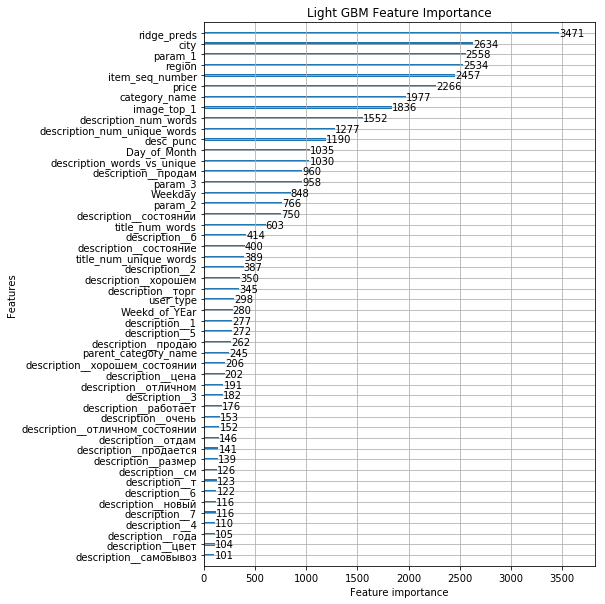

In [141]:
%matplotlib inline
f, ax = plt.subplots(figsize=[7,10]) 
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax) 
plt.title("Light GBM Feature Importance") 


In [142]:
lgpred = lgb_clf.predict(testing) 
blend = 0.8*lgpred + 0.2*ridge_oof_test[:, 0] 

lgsub = pd.DataFrame(blend, columns=["deal_probability"], 
                    index=testdex)



/Users/oharasoh/.pyenv/versions/3.5.3/lib/python3.5/site-packages/lightgbm/basic.py:447: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


In [143]:
lgsub["deal_probability"] = lgsub['deal_probability'].clip(0.0, 1.0)
lgsub.to_csv("lgsub.csv", index=True, header=True) 

In [144]:
for_valid = pd.DataFrame({"prediction": blend, "t": validation}, index=testdex)

In [20]:
import pandas as pd 
import numpy as np
import time 
import gc

In [21]:
np.random.seed(42)

from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score 
from sklearn.model_selection import StratifiedKFold

from keras.models import Model 
from keras.layers import Input, Dropout, Dense, Embedding, SpatialDropout1D,concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, BatchNormalization, Conv1D, MaxPooling1D, Flatten 
from keras.preprocessing.sequence import pad_sequences 
from keras.preprocessing import text, sequence 
from keras.callbacks import Callback 
from keras import backend as K 
from keras.models import Model 

from keras import optimizers 

from sklearn.preprocessing import LabelBinarizer 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler 

import warnings 

warnings.filterwarnings('ignore') 

import os 
os.environ['OMP_NUM_THREADS'] = '4' 

import threading 
import multiprocessing 
from multiprocessing import Pool, cpu_count 
from contextlib import closing 
cores = 4 

from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred))) 

In [ ]:
def preprocess_dataset(df):
    t1 = time.time() 
    print("Filling Missing Values ...")
    param_list = ['param_1', 'param_2', 'param_3']
    df['price'] = df['price'].fillna(0).astype('float32') 
    for i in range(len(param_list)):
        df[param_list[i]].fillna(value='missing', inplace=True) 
        df[param_list[i]] = df[param_list[i]].astype(str) 
   
    print("Casting data types to type Category....") 
    df['category_name'] = df['category_name'].astype('category') 
    df['parent_category_name'] = df['parent_category_name'].astype('category') 
    df['region'] = df['region'].astype('category') 
    df['city'] = df['city'].astype('category') 
    
    df['image_top_1'].fillna(value='missing', inplace=True) 
    df['image_code'] = df['image_top_1'].astype('str') 
    del df['image_top_1'] 
    gc.collect(); 
    df['week'] = pd.to_datetime(df['activation_date']).dt.week.astype('uint8')
    df['day'] = pd.to_datetime(df['activation_date']).dt.day.astype('uint8')
    df['wday'] = pd.to_datetime(df['activation_date']).dt.dayofweek.astype('uint8')
    
    del df['activation_date'] 
    gc.collect(); 
    
    print('Creating New Feature ...')
    df['param123'] = (df['param_1']+'_'+df['param_2']+'_'+df['param_3']).astype(str)
    del df['param_2'], df['param_3']
    gc.collect();
    
    print('PreProcessing Function completed.') 
    print("columns is ", df.columns)
    
    return df 


def keras_fit(train):
    
    t1 = time.time() 
    train['title_description'] = (train['title'] + " " + train['description']).astype(str) 
    del train['description'], train['title'] 
    gc.collect() 
    
    print("Start Tokenization ...")
    tokenizer = text.Tokenizer(num_words=max_words_title_description)
    # Tokenizerはscikitlearnのツールっぽい
    all_text = np.hstack([train['title_description'].str.lower()])
    tokenizer.fit_on_texts(all_text) 
    del all_text 
    gc.collect()
    
    print("Loading Test for Label Encoding on Train + Test") 
    use_cols_test = ['region', 'city', 'parent_category_name', 'category_name',
                    'param_1', 'param_2', 'param_3', 'image_top_1', 'activation_date'] 
    test = pd.read_csv("test.csv", usecols=use_cols_test, nrows=20000) 
    
    test['image_top_1'] = test['image_top_1'].fillna('missing') 
    test['image_code'] = test['image_top_1'].astype('str') 
    del test['image_top_1'] 
    gc.collect() 
    
    test['week'] = pd.to_datetime(test['activation_date']).dt.week.astype('uint8')
    test['day'] = pd.to_datetime(test['activation_date']).dt.day.astype('uint8') 
    test['wday'] = pd.to_datetime(test['activation_date']).dt.dayofweek.astype('uint8') 
    
    del test['activation_date'] 
    
    test['param_1'].fillna(value='missing', inplace=True) 
    test['param_1'] = test['param_1'].astype(str) 
    test['param_2'].fillna(value='missing', inplace=True) 
    test['param_2'] = test['param_2'].astype(str) 
    test['param_3'].fillna(value='missing', inplace=True) 
    test['param_3'] = test['param_3'].astype(str) 
    
    print('Creating New Feature....') 
    test['param123'] = (test['param_1']+'_'+test['param_2']+'_' +test['param_3']).astype(str)
    del test['param_2'], test['param_3']
    gc.collect() 
    
    ntrain = train.shape[0] 
    DF = pd.concat([train, test], axis=0) 
    del train, test 
    gc.collect() 
    print(DF.shape) 
    
    print("Start Label Encoding process....")
    le_region = LabelEncoder() 
    le_region.fit(DF.region) 
    
    le_city = LabelEncoder() 
    le_city.fit(DF.city) 
    
    le_category_name = LabelEncoder() 
    le_category_name.fit(DF.category_name)
    
    le_parent_category_name = LabelEncoder() 
    le_parent_category_name.fit(DF.parent_category_name) 
    
    le_param_1 = LabelEncoder() 
    le_param_1.fit(DF.param_1) 
    
    le_param123 = LabelEncoder() 
    le_param123.fit(DF.param123) 
    
    le_image_code = LabelEncoder() 
    le_image_code.fit(DF.image_code) 
    
    le_week = LabelEncoder()
    le_week.fit(DF.week)
    le_day = LabelEncoder()
    le_day.fit(DF.day)
    le_wday = LabelEncoder()
    le_wday.fit(DF.wday)  
    
    train = DF[0:ntrain] 
    del DF 
    gc.collect() 
    
    train['price'] = np.log1p(train['price']) 
    train['avg_days_up_user'] = np.log1p(train['avg_days_up_user']) 
    train['avg_times_up_user'] = np.log1p(train['avg_times_up_user'])
    train['n_user_items'] = np.log1p(train['n_user_items']) 
    train['item_seq_number'] = np.log(train['item_seq_number']) 
    print("Fit to Train Function completed.")
    
    return train, tokenizer,le_region, le_city, le_category_name, le_parent_category_name, le_param_1, le_param123, le_image_code, le_week, le_day, le_wday


def keras_train_transform(df):
    t1 = time.time() 
    
    df['seq_title_description'] = tokenizer.texts_to_sequences(df.title_description.str.lower())
    print("Transform done for test") 
    print("Time taken for Sequence Token is " + str(time.time() - t1))
    del train['title_description'] 
    gc.collect()
    
    df['region'] = le_region.transform(df['region'])  # エンコードしたもので変換
    df['city'] = le_city.transform(df['city']) 
    df['category_name'] = le_category_name.transform(df['category_name']) 
    df['parent_category_name'] = le_parent_category_name.transform(df['parent_category_name']) 
    df['param_1'] = le_param_1.transform(df['param_1']) 
    df['param123'] = le_param123.transform(df['param123'])
    df['day'] = le_day.transform(df['day']) 
    df['week'] = le_week.transform(df['week']) 
    df['wday'] = le_wday.transform(df['wday']) 
    df['image_code'] = le_image_code.transform(df['image_code']) 
    
    print("Transform on test function completed.")
    
    return df 

def keras_test_transform(df):
    
    t1 = time.time() 
    df['title_description'] = (df['title']+" "+df['description']).astype(str) 
    del df['description'], df['title'] 
    gc.collect() 
    
    df['seq_title_description']= tokenizer.texts_to_sequences(df.title_description.str.lower()) 
    print("Transform done for test") 
    print("Time taken for Sequence Token is " + str(time.time()-t1)) 
    
    del df['title_description'] 
    gc.collect() 
    
    df['region'] = le_region.transform(df['region']) 
    df['city'] = le_city.transform(df['city']) 
    df['cateogyr_name'] = le_category_name.transform(df['category_name']) 
    df['parent_category_name'] = le_parent_category_name.transform(df['parent_category_name'])
    df['param_1'] = le_param_1.transform(df['param_1']) 
    df['param123'] = le_param123.transform(df['param123'])
    df['day'] = le_day.transform(df['day']) 
    df['week'] = le_week.transform(df['week']) 
    df['wday'] = le_wday.transform(df['wday']) 
    df['image_code'] = le_image_code.transform(df['image_code']) 
    
    df['price'] = np.log1p(df['price'])
    df['item_seq_number'] = np.log(df['item_seq_number']) 
    df['avg_days_up_user'] = np.log1p(df['avg_days_up_user'])
    df['avg_times_up_user'] = np.log1p(df['avg_times_up_user']) 
    df['n_user_items'] = np.log1p(df['n_user_items']) 
    
    print("Transform on test function completed") 
    
    return df 

def get_keras_data(df):
    X = {
        'seq_title_description' : pad_sequences(df.seq_title_description, 
                                               max_len=max_seq_title_description_length)
        # 同じ長さになるようにする
        ,'region': np.array(df.region) 
        ,'city': np.array(df.city) 
        ,'category_name': np.array(df.category_name) 
        ,'parent_category_name': np.array(df.parent_category_name) 
        ,'param_1': np.array(df.param_1) 
        ,'param123':np.array(df.param123)
        ,'image_code':np.array(df.image_code) 
        ,'avg_ad_days':np.array(df.avg_days_up_user) 
        ,'avg_ad_times':np.array(df.avg_times_up_user) 
        ,'n_user_items': np.array(df.n_user_items) 
        ,'price':np.array(df[['price']]) 
        ,'item_seq_number':np.array(df[['item_seq_number']])
        ,'day': np.array(df.day)
        ,'week': np.array(df.week) 
        ,'wday': np.array(df.wday)
    }
    
    print("Data ready for Vectorization") 
    
    return X 


    
    
    
    
    
    

In [ ]:
dtypes_train = {
    "price": "float32",
    "deal probability": "float32",
    "item_seq_number": "uint32"
}

use_cols = ['item_id', 'user_id', 'image_top_1', 'region', 'city', 
            'parent_category_name', 'category_name', 'param_1', 
            'param_2', 'param_3', 'title', 'description', 'price', 
            'item_seq_number', 'activation_date', 'deal_probability']
train = pd.read_csv("train.csv", parse_dates = ['activation_date'],
                   usecols=use_cols, dtype=dtypes_train, nrows=10000) 

train_features = pd.read_csv("aggregated_features.csv",nrows=10000) 
train = train.merge(train_features, on =['user_id'], how='left') 
del train_features 
gc.collect() 

train['avg_days_up_user'] = train['avg_days_up_user'].fillna(0).astype('uint32') 
train['avg_times_up_user'] = train['avg_times_up_user'].fillna(0).astype('uint32')
train['n_user_items'] = train['n_user_items'].fillna(0).astype('uint32') 

y_train = np.array(train['deal_probability']) 

del train['deal_probability'] 
gc.collect() 

max_seq_title_description_length = 100
max_words_title_description = 200000

train = preprocess_dataset(train)
train, tokenizer, le_region, le_city, le_category_name, le_parent_category_name, le_param_1, le_param123, le_image_code,le_week, le_day, le_wday= keras_fit(train)
train = keras_train_transform(train)
print("Tokenization done and TRAIN READY FOR Validation splitting")

# Calculation of max values for Categorical fields 

max_region = np.max(train.region.max())+2
max_city= np.max(train.city.max())+2
max_category_name = np.max(train.category_name.max())+2
max_parent_category_name = np.max(train.parent_category_name.max())+2
max_param_1 = np.max(train.param_1.max())+2
max_param123 = np.max(train.param123.max())+2
max_week = np.max(train.week.max())+2
max_day = np.max(train.day.max())+2
max_wday = np.max(train.wday.max())+2
max_image_code = np.max(train.image_code.max())+2


del train['item_id'], train['user_id']
gc.collect()

Filling Missing Values ...
Casting data types to type Category....
Creating New Feature ...
PreProcessing Function completed.
columns is  Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'title', 'description', 'price',
       'item_seq_number', 'avg_days_up_user', 'avg_times_up_user',
       'n_user_items', 'image_code', 'week', 'day', 'wday', 'param123'],
      dtype='object')
Start Tokenization ...
Loading Test for Label Encoding on Train + Test
Creating New Feature....
(30000, 18)
Start Label Encoding process....
Fit to Train Function completed.


In [ ]:
EMBEDDING_DIM1 = 300 
EMBEDDING_FILE1 = "cc.ru.300.vec" 
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index1 = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE1))
# rstripは空白だけでなく改行も削除する

vocab_size = len(tokenizer.word_index) + 2 
EMBEDDING_DIM1 = 300 
embedding_matrix1 = np.zeros((vocab_size, EMBEDDING_DIM1)) 
print(embedding_matrix1.shape) 

c = 0 
c1 = 0
w_Y = [] 
w_No = [] 
for word, i in tokenizer.word_index.items():
    if word in embeddings_index1:
        c += 1 
        embedding_vector = embeddings_index1[word] 
        w_Y.append(word)
    else:
        embedding_vector = None 
        w_No.append(word) 
        c1 += 1 
    if embedding_vector is not None:
        embedding_matrix1[i] = embedding_vector 
        
print(c, c1, len(w_No), len(w_Y)) 
print(embedding_matrix1.shape) 
del embeddings_index1 
gc.collect() 

print(" FAST TEXT DONE") 

In [ ]:
print(vocab_size)

In [ ]:
def RNN_model():
    # Inputs 
    seq_title_description = Input(shape=[100], name='seq_title_description') 
    region = Input(shape=[1], name='region') 
    city = Input(shape=[1], name='city') 
    category_name = Input(shape=[1], name='category_name') 
    parent_category_name = Input(shape=[1], name='parent_category_name')
    param_1 = Input(shape=[1], name='param_1') 
    param123 = Input(shape=[1], name='param123')
    image_code = Input(shape=[1], name='image_code')
    price = Input(shape=[1], name='price') 
    item_seq_number = Input(shape=[1], name='item_seq_number')
    avg_ad_days = Input(shape=[1], name='avg_ad_days')
    avg_ad_times = Input(shape=[1], name='avg_ad_times')
    n_user_items = Input(shape=[1], name='n_user_items') 
    week = Input(shape=[1], name='week') 
    day = Input(shape=[1], name='day') 
    wday = Input(shape=[1], name='wday') 
    
    # Embeddings layers 
    emb_seq_title_description = Embedding(vocab_size, EMBEDDING_DIM1, 
                                         weights = [embedding_matrix1], trainable=False)(seq_title_description)
    emb_region = Embedding(vocab_size, 10)(region) 
    emb_city = Embedding(vocab_size, 10)(city) 
    emb_category_name = Embedding(vocab_size, 10)(parent_category_name) 
    emb_param_1 = Embedding(vocab_size, 10)(param_1) 
    emb_param123 = Embedding(vocab_size, 10)(param123) 
    emb_image_code = Embedding(vocab_size, 10)(image_code) 
    emb_day = Embedding(vocab_size, 10)(day)
    emb_week = Embedding(vocab_size, 10)(week) 
    emb_wday = Embedding(vocab_size, 10)(wday)
    
    rnn_layer1 = GRU(50)(emb_seq_title_description) 
    
    main_l = concatenate([
        rnn_layer1 
        ,Flatten()(emb_region)
        ,Flatten()(emb_city) 
        ,Flatten()(emb_cateogry)
        ,Flatten()(emb_param_1) 
        ,Flatten()(emb_param123)
        ,Flatten()(emb_image_code)
        ,Flatten()(emb_week)
        ,Flatten()(emb_day)
        ,Flatten()(emb_wday)
        ,avg_ad_days
        ,avg_ad_times
        ,n_user_items
        ,price
        ,item_seq_number
    ])
    
    main_l = Dropout(0.1)(Dense(512,activation='relu')(main_l))
    main_l = Dropout(0.1)(Dense(512,activation='relu')(main_l)) 
    
    output = Dense(1, activation='sigmoid')(main_l) 
    #model 
    model = Model([seq_title_description, region, city, category_name,
                  parent_category_name, param_1, param123, price, item_seq_number, image_code, avg_ad_days,
                  avg_ad_times, n_user_items,week, day, 
                   wday], output) 
    model.compile(optimizer='adam', 
                 loss=root_mean_squared_error, 
                 metrics=[root_mean_squared_error])
    return model 

def rmse(y, y_pred):
    Rsum = np.sum((y-y_pred)**2)
    n = y.shape[0] 
    RMSE = np.sqrt(Rsum/n) 
    return RMSE 

def eval_model(model, X_test1):
    val_preds = model.predict(X_test1) 
    y_pred = val_preds[:, 0] 
    
    y_true = np.array(y_test1) 
    
    yt = pd.DataFrame(y_true) 
    yp = pd.DataFrame(y_pred) 
    print(yt.isnull().any()) 
    print(yp.isnull().any()) 
    
    v_rmse = rmse(y_true, y_pred) 
    print("RMSE for VALIDATION SET: "+str(v_rmse)) 
    return v_rmse 

exp_decay = lambda init,fin, steps: (init/fin)**(1/(steps-1)) -1 

In [ ]:
def predictions(model):
    import time
    t1 = time.time() 
    def load_test():
        for df in pd.read_csv("test.csv", chunksize=10000):
            yield df 
            
    item_ids = np.array([], dtype=np.int32) 
    preds = np.array([], dtype=np.float32) 
    
    i  = 0
    
    for df in load_test():
        i += 1 
        print(df.dtypes) 
        item_id = df['item_id']
        print("Chunk number is " + str(i)) 
        
        test = preprocess_dataset(df) 
        
        train_features = pd.read_csv("aggregated_features.csv") 
        test= test.merge(train_features, on=['user_od'], how='left') 
        del train_features 
        gc.collect() 
        
        print(test.dtypes) 
        test['avg_days_up_user'] = test['avg_days_up_user'].fillna(0).astype('uint32')
        test['avg_times_up_user'] = test['avg_times_up_user'].fillna(0).astype('uint32') 
        test['n_user_items'] = test['n_user_items'].fillna(0).astype('uint32') 
        test = keras_test_transform(test) 
        del df 
        gc.collect() 
        
        print(test.dtypes) 
        X_test = get_keras_data(test) 
        del test 
        gc.collect() 
        
        Batch_Size = 512
        preds1 = modelRNN.predict(X_test, batch_size=Batch_Size, verbose=1)
        print("preds1.shape is ",preds1.shape) 
        del X_test
        gc.collect() 
        print("RNN prediction is done") 
        
        preds1 = preds1.reshape(-1, 1) 
        preds1 = np.clip(preds1, 0, 1) 
        print(preds1.shape) 
        item_ids = np.append(item_ids, item_id) 
        print("item_ids.shape is ", item_ids.shape)
        preds = np.append(preds, preds1) 
        print("preds.shape is ", preds.shape)
        
    print("All chunks done") 
    t2 = time.time() 
    print("Total time for Parallel Batch Prediction is " + str(t2-t1))
    return preds 


In [ ]:
'item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'title', 'description', 'price',
       'item_seq_number', 'avg_days_up_user', 'avg_times_up_user',
       'n_user_items', 'image_code', 'week', 'day', 'wday', 'param123'],
      dtype='object

In [ ]:
train1 = np.array(train.values) 
print(train.columns)
del train 
gc.collect() 

# このあたりは関数が呼び出されたときに再度検討する
def get_data_frame(dataset):
    DF = pd.DataFrame() 
    DF['avg_days_up_user'] = np.array(dataset[:,0])
    DF['avg_times_up_user'] = np.array(dataset[:, 1]) 
    DF['category_name'] = np.array(dataset[:, 2]) 
    DF['city'] = np.array(dataset[:, 3]) 
    DF['day'] = np.array(dataset[:, 4])
    DF['image_code'] = np.array(dataset[:, 4])
    DF['item_seq_number'] = np.array(dataset[:, 5]) 
    DF['n_user_items'] = np.array(dataset[:, 6]) 
    DF['param123'] = np.array(dataset[:, 7]) 
    DF['param_1'] = np.array(dataset[:, 8]) 
    DF['parent_category_name'] = np.array(dataset[:, 9]) 
    DF['price'] = np.array(dataset[:, 10]) 
    DF['region'] = np.array(dataset[:, 11]) 
    DF['wday']  = np.array(dataset[:, 12]) 
    DF['week'] = np.array(dataset[:, 13]) 
    DF['seq_title_description'] = np.array(dataset[:, 14]) 
    
    return DF 

In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold 
import time 
skf = KFold(n_splits=3)
Kfold_preds_final = [] 
k = 0 
RMSE = 0 

for train_idx, test_idx in skf.split(train1, y_train):
    
    print("Number of Folds.. " + str(k+1)) 
    
    epochs = 1 
    batch_size = 512 
    steps = (int(train1.shape[0]/batch_size))*epochs 
    lr_init, lr_fin = 0.009, 0.0045 
    lr_decay = exp_decay(lr_init, lr_fin, steps) 
    modelRNN = RNN_model() 
    K.set_value(modelRNN.optimizer.lr, lr_init) 
    K.set_value(modelRNN.optimizer.decay, lr_decay) 
    
    # K Fold Split 
    
    X_train1, X_test1 = train1[train_idx], train1[test_idx] 
    print(X_train1.shape, X_test1.shape) 
    y_train1, y_test1 = y_train[train_idx], y_train[test_idx] 
    print(y_train1.shape, y_test1.shape) 
    gc.collect();
    
    print(type(X_train1)) 
    print(X_train1.shape) 
    print(type(X_train1[:, 12])) 
    
    X_train_final = get_data_frame(X_train1) 
    X_test_final = get_data_frame(X_test1) 
    
    del X_train1, X_test1 
    gc.collect() 
    
    print(type(X_train1)) 
    print(X_train1.shape) 
    print(type(X_train1[:, 12])) 
    
    X_trian_f = get_data_frame(X_train_final) 
    X_test_f = get_keras_data(X_test_final) 
    
    del X_train_final, X_test_final 
    gc.collect() 
    
    for i in range(3):
        hist = modelRNN.fit(X_train_f, y_train1, batch_size=batch_size+(batch_size*(2*i)),
                           epochs=epochs, validation_data=(X_test_f, y_test1), verbose=1) 
        
        del X_train_f 
        gc.collect() 
        
        v_rmse = eval_model(modelRNN, X_test_f) 
        RMSE.apend(v_rmse) 
        
        del X_test_f 
        del y_train1, y_test1 
        gc.collect() 
        
        preds = predictions(modelRNN ) 
        del modelRNN 
        gc.collect() 
        
        print("Predictions done for Fold " + str(k)) 
        print(preds.shape) 
        Kfold_preds_final.append(preds) 
        del preds 
        gc.collect() 
        print("Number of folds completed..." + str(len(Kfold_preds_final))) 
        print(Kfold_preds_final[k][0:10]) 
        
    print("All Folds completed" + str(k+1)) 
    print("RNN FOLD MODEL Done") 
    